In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import word2vec
import spacy
import nltk

nlp = spacy.load("en_core_web_lg")

from warnings import filterwarnings

filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data/cleaned_data.csv")

In [3]:
df.head()

,Head,Body,Tags,First Answer,Tags Count
0,brain segmentation to 3d model,my goal is to take a dataset of brain tumor se...,computer-vision python,No Answer,2
1,active learning regression with random forest,i have a dataset of about 8k points and i am t...,machine-learning regression uncertainty-quanti...,No Answer,5
2,comparing reinforcement learning models,i am currently completing my thesis on optimis...,reinforcement-learning policy-gradients monte-...,No Answer,4
3,why good model that performs great on holdout ...,i have this binary regression model that has 5...,deep-learning deep-neural-networks prediction ...,No Answer,5
4,what are reservoir computers used for today,reservoir computers were very popular in the e...,machine-learning recurrent-neural-networks res...,No Answer,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48811 entries, 0 to 48810
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Head          48811 non-null  object
 1   Body          48811 non-null  object
 2   Tags          48811 non-null  object
 3   First Answer  48811 non-null  object
 4   Tags Count    48811 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [5]:
# Body Features Demographic Distribution

print("Max length of the body: ", df["Body"].str.len().max())
print("Min length of the body: ", df["Body"].str.len().min())
print("Mean length of the body: ", df["Body"].str.len().mean())
print("Median length of the body: ", df["Body"].str.len().median())

Max length of the body:  26347
Min length of the body:  19
Mean length of the body:  918.0814775358014
Median length of the body:  661.0


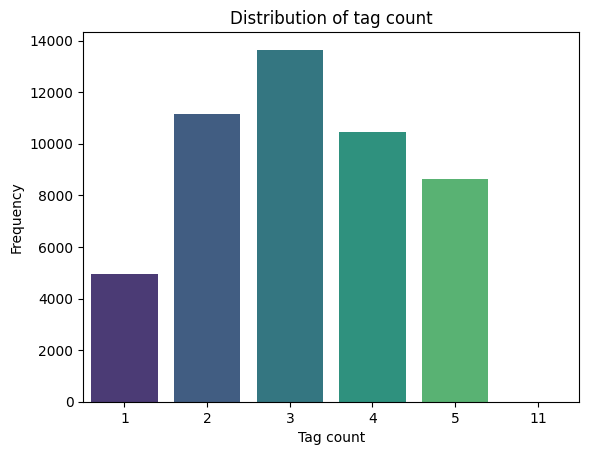

In [6]:
# plot distribution of tag count
sns.countplot(data=df, x="Tags Count", color="blue", palette="viridis")
plt.title("Distribution of tag count")
plt.ylabel("Frequency")
plt.xlabel("Tag count")
plt.show()

In [7]:
# vectorize tags
tag_vectorizer = CountVectorizer(tokenizer=lambda x: str(x).split())
tag_mat = tag_vectorizer.fit_transform(df["Tags"])

In [8]:
# get names of tags
tag_names = tag_vectorizer.get_feature_names_out()
type(tag_names), len(tag_names)

(numpy.ndarray, 2693)

In [9]:
tag_names[:20]

array(['.net', '1d-convolution', '2d-convolution', '2sls',
       '3d-convolution', '3d-reconstruction', '5-star-scheme',
       '8-puzzle-problem', '8-queens-problem', 'a', 'a-star', 'a3c',
       'ab-test', 'abbreviation', 'absolute-risk', 'absolute-value',
       'academia', 'accelerometer', 'accept-reject', 'accuracy'],
      dtype=object)

In [10]:
tag_freq = tag_mat.sum(axis=0)

In [11]:
# store tag names and frequency as a pandas series
tag_freq_ser = pd.Series(tag_freq.A1, index=tag_names)
tag_freq_ser.sort_values(ascending=False, inplace=True)
tag_freq_ser.head(10)

machine-learning          8148
r                         4187
regression                3840
deep-learning             3435
neural-networks           3006
data-request              2527
python                    2503
reinforcement-learning    2348
classification            2200
time-series               2039
dtype: int64

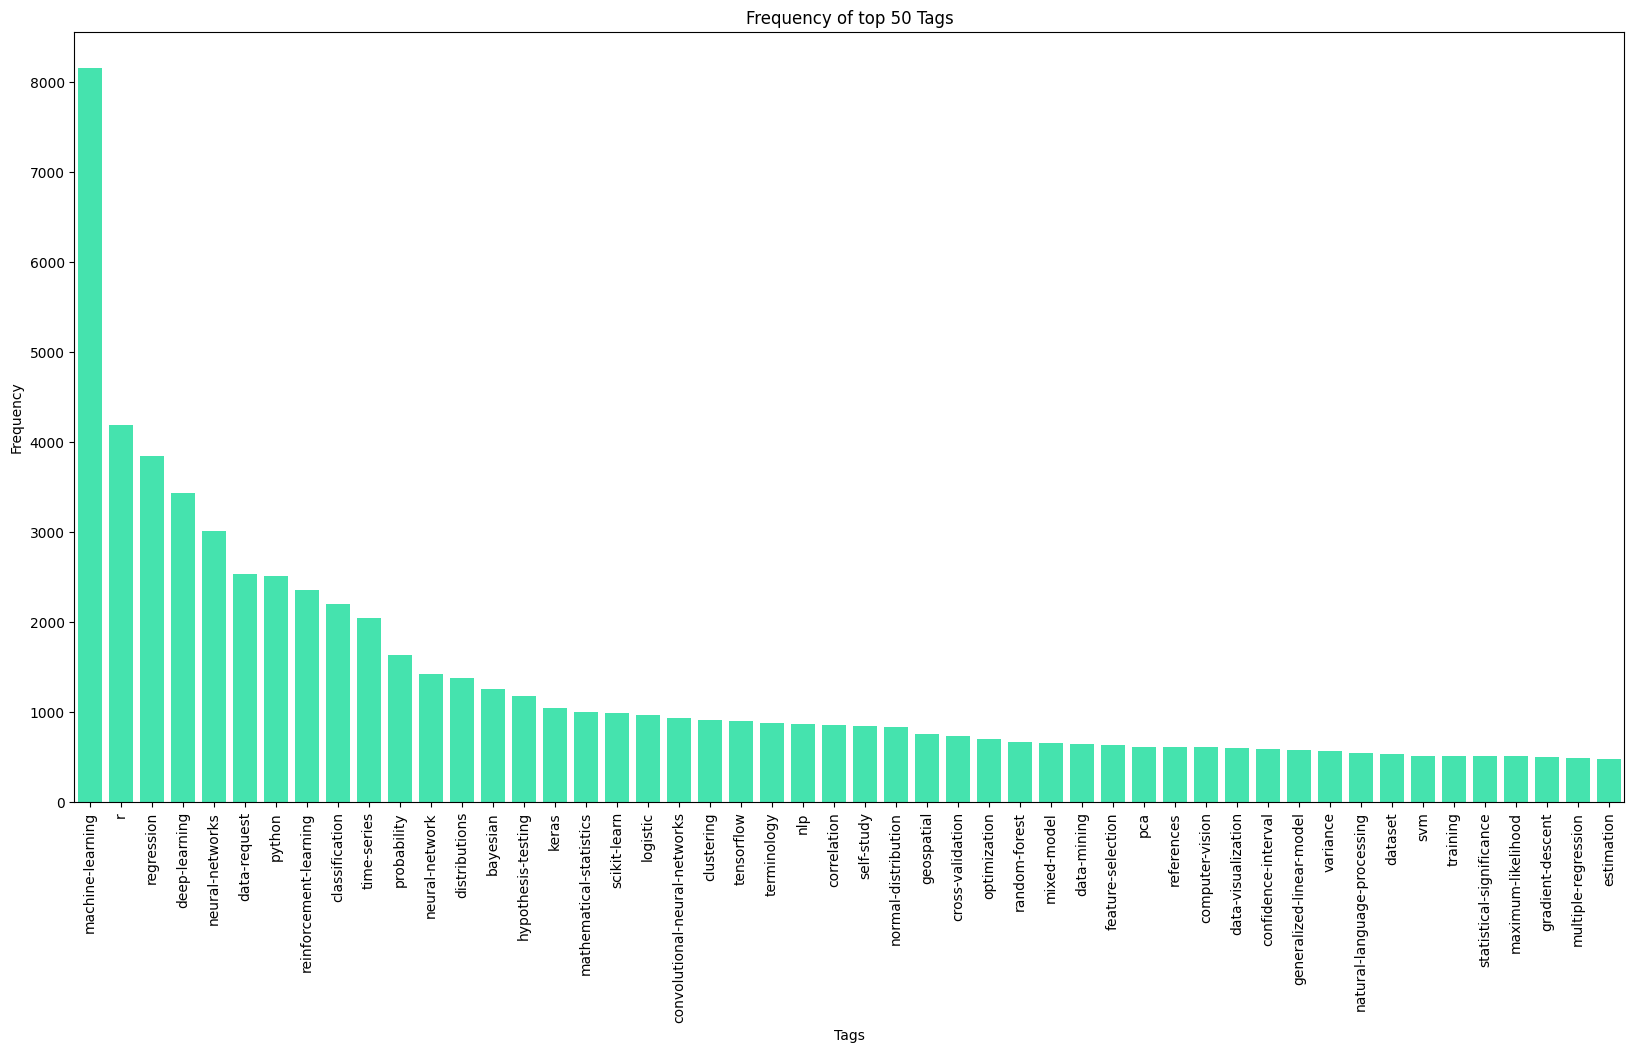

In [12]:
# Frequency top 50 tags
fig = plt.figure(figsize=[20, 10])
sns.barplot(
    x=tag_freq_ser.iloc[:50].index,
    y=tag_freq_ser.iloc[:50].values,
    color=sns.xkcd_rgb["greenish cyan"],
)
plt.title("Frequency of top 50 Tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

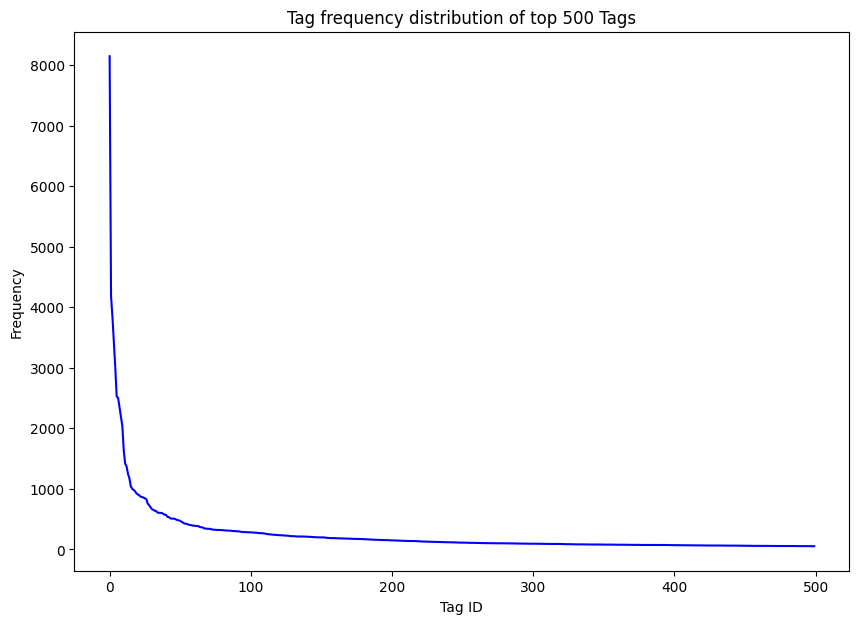

In [13]:
# plot distribution of tag frequency (top 500)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:500].values, c="blue")
plt.title("Tag frequency distribution of top 500 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

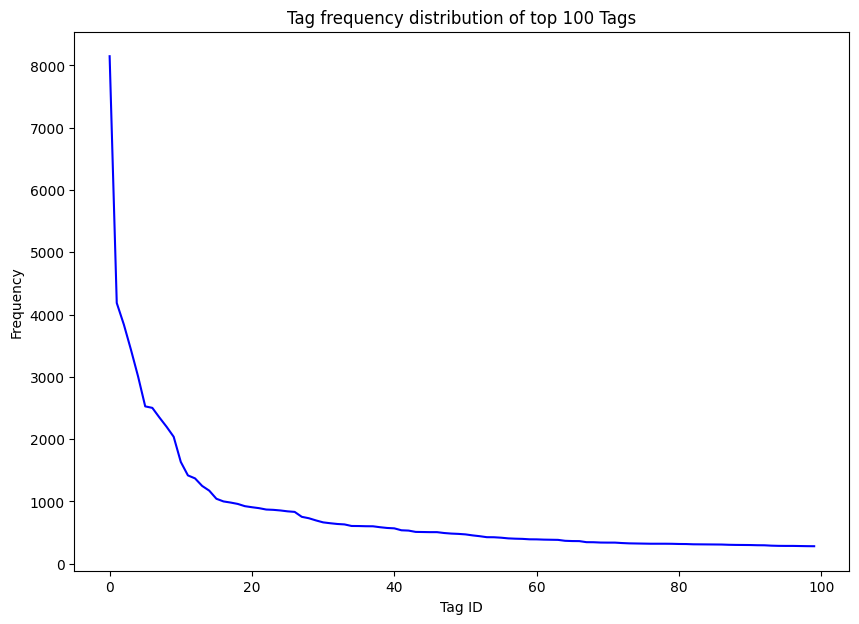

In [14]:
# plot distribution of tag frequency (top 100)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:100].values, c="blue")
plt.title("Tag frequency distribution of top 100 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

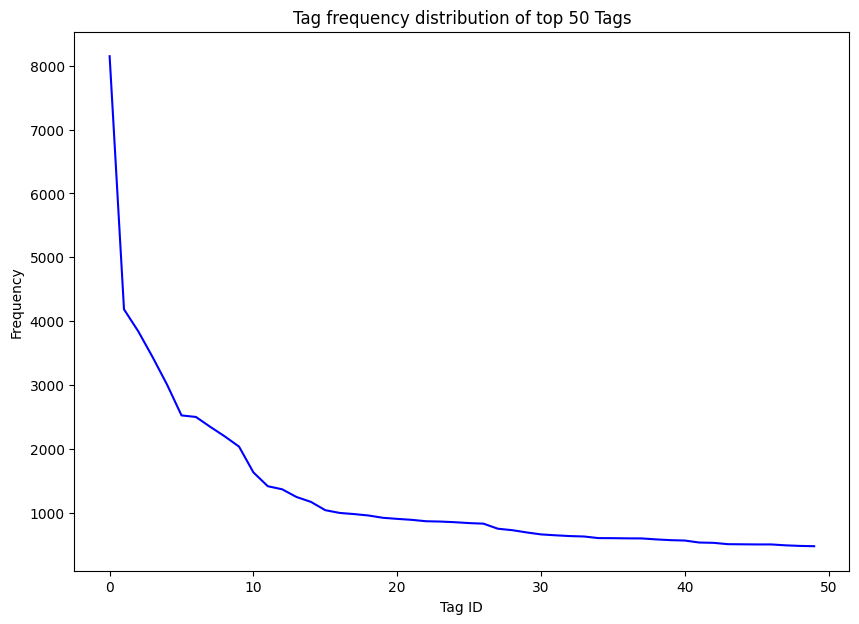

In [15]:
# plot distribution of tag frequency (top 50)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:50].values, c="blue")
plt.title("Tag frequency distribution of top 50 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

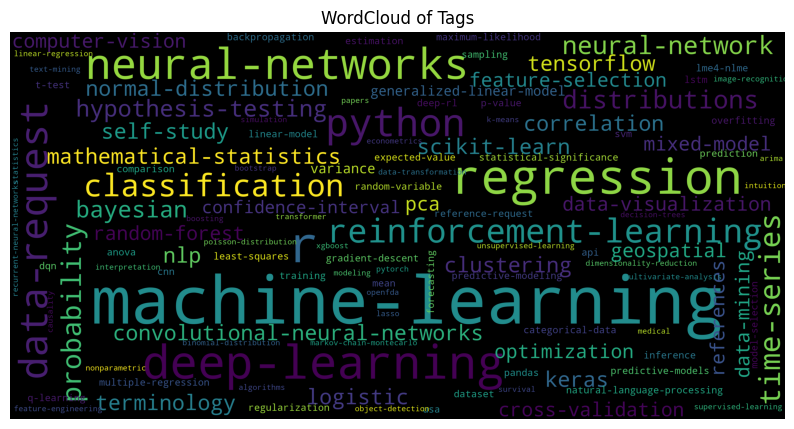

In [16]:
# plot word count for tags
wordcloud = WordCloud(
    background_color="black",
    max_words=200,
    scale=10,
).generate_from_frequencies(tag_freq_ser)
fig = plt.figure(figsize=[10, 10])
plt.title("WordCloud of Tags")
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

In [17]:
df["Text"] = df["Head"] + " " + df["Body"]
# Create a list of stopwords
stopwords_nltk = nltk.corpus.stopwords.words("english")
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
stopwords = list(
    set(
        stopwords_nltk
        + list(stopwords_spacy)
        + list(STOPWORDS)
        + list("abdefghijklmnopqstuvwxyz")
    )
)
print(len(stopwords))

433


In [18]:
def remove_stopwords(text):
    return " ".join(
        [word for word in str(text).split() if word.strip() not in stopwords]
    )

df["Text_Uncleaned"] = df["Text"].apply(lambda x: remove_stopwords(x))

In [19]:
# Create Word2Vec model from text column

list_of_sent = [sent.split() for sent in df["Text_Uncleaned"].values]

w2v_model = word2vec.Word2Vec(list_of_sent, vector_size=100, window=5, workers=4)

w2v_model.wv.most_similar("detection")

[('anomaly', 0.8060661554336548),
 ('detector', 0.7250853180885315),
 ('detecting', 0.7000943422317505),
 ('fraud', 0.6950052976608276),
 ('segmentation', 0.6928040981292725),
 ('yolo', 0.6867391467094421),
 ('outlier', 0.6580128073692322),
 ('novelty', 0.6540268659591675),
 ('detect', 0.6414740085601807),
 ('tracking', 0.636224627494812)]

### Cleaning the Body Feature for Modeling
- #### Lemmatization
- #### Remove stopwords
- #### Remove extra spaces

In [20]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_body(text):
    text = str(text).lower()
    text = " ".join([word for word in text.split() if word not in stopwords])
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df["Text_Cleaned"] = df["Text"].apply(clean_body)


In [21]:
# Create Word2Vec model from text column

list_of_sent = [sent.split() for sent in df["Text_Cleaned"].values]

w2v_model = word2vec.Word2Vec(list_of_sent, vector_size=100, window=5, workers=4)

w2v_model.wv.most_similar("detection")

[('detecting', 0.7878516912460327),
 ('anomaly', 0.779015839099884),
 ('detector', 0.7398408055305481),
 ('intrusion', 0.6752329468727112),
 ('segmentation', 0.6656692624092102),
 ('yolo', 0.6605998277664185),
 ('detect', 0.6558012366294861),
 ('tracking', 0.6461852788925171),
 ('detected', 0.6435737013816833),
 ('fraud', 0.6433996558189392)]